<a href="https://colab.research.google.com/github/sr-bn98/skills-copilot-codespaces-vscode/blob/main/lastseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Brain Tumor Segmentation**

A 2D brain tumor segmentation dataset

The dataset contains 3064 pairs of MRI brain images and their respective binary mask indicating tumor.

The link : https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [ ]:
!pip install torchinfo

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"sarabana","key":"a0d4a93e7cb3c71b75d6870c787d479b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 95% 295M/312M [00:02<00:00, 105MB/s]
100% 312M/312M [00:02<00:00, 128MB/s]


unzip our zip file



In [ ]:

%%capture
!unzip brain-tumor-segmentation.zip


In [ ]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━

In [ ]:

import os
import torch
import monai
import random

import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import cv2
from PIL import Image

import shutil
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.11/dist-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


defining necessary directories

In [ ]:
images_dir='/content/images'
masks_dir='/content/masks'


train_dir='/content/train'
test_dir='/content/test'

train_msk_dir='/content/train/masks'
train_img_dir='/content/train/images'

test_msk_dir='/content/test/masks'
test_img_dir='/content/test/images'


identifying duplicates

In [ ]:
import hashlib


def compute_image_hash(image_path):
    with Image.open(image_path) as img:
        img = img.resize((256, 256)).convert("RGB")
        return hashlib.md5(img.tobytes()).hexdigest()


In [ ]:

def check_duplicates(directory):
    hash_dict = {}
    duplicate_files = []

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        file_hash = compute_image_hash(file_path)

        if file_hash in hash_dict:
            duplicate_files.append((filename, hash_dict[file_hash]))
        else:
            hash_dict[file_hash] = filename

    return duplicate_files


duplicate_images = check_duplicates(images_dir)
duplicate_masks = check_duplicates(masks_dir)


if duplicate_images:
    print("Duplicate images found:")
    for dup in duplicate_images:
        print(f"{dup[0]} is a duplicate of {dup[1]}")
else:
    print("No duplicate images found.")

if duplicate_masks:
    print("Duplicate masks found:")
    for dup in duplicate_masks:
        print(f"{dup[0]} is a duplicate of {dup[1]}")
else:
    print("No duplicate masks found.")


No duplicate images found.
No duplicate masks found.


In [ ]:
img_list = glob(os.path.join('/content/images', '*'))
msk_list = glob(os.path.join('/content/masks', '*'))
import random
random.seed(42)

print('There are:', len(img_list), 'images')
print('A random image in img_list:', random.choice(img_list))
print('There are:', len(msk_list), 'masks')
print('A random mask in msk_list:', random.choice(msk_list))




There are: 3064 images
A random image in img_list: /content/images/259.png
There are: 3064 masks
A random mask in msk_list: /content/masks/1977.png


In [ ]:
images_dir='/content/images'
masks_dir='/content/masks'


train_dir='/content/train'
test_dir='/content/test'


os.mkdir(train_dir)
os.mkdir(test_dir)


train_msk_dir='/content/train/masks'
train_img_dir='/content/train/images'

test_msk_dir='/content/test/masks'
test_img_dir='/content/test/images'


os.mkdir(train_msk_dir)
os.mkdir(train_img_dir)

os.mkdir(test_msk_dir)
os.mkdir(test_img_dir)


[('1090.png', '1090.png'), ('975.png', '975.png'), ('2011.png', '2011.png'), ('1901.png', '1901.png')]


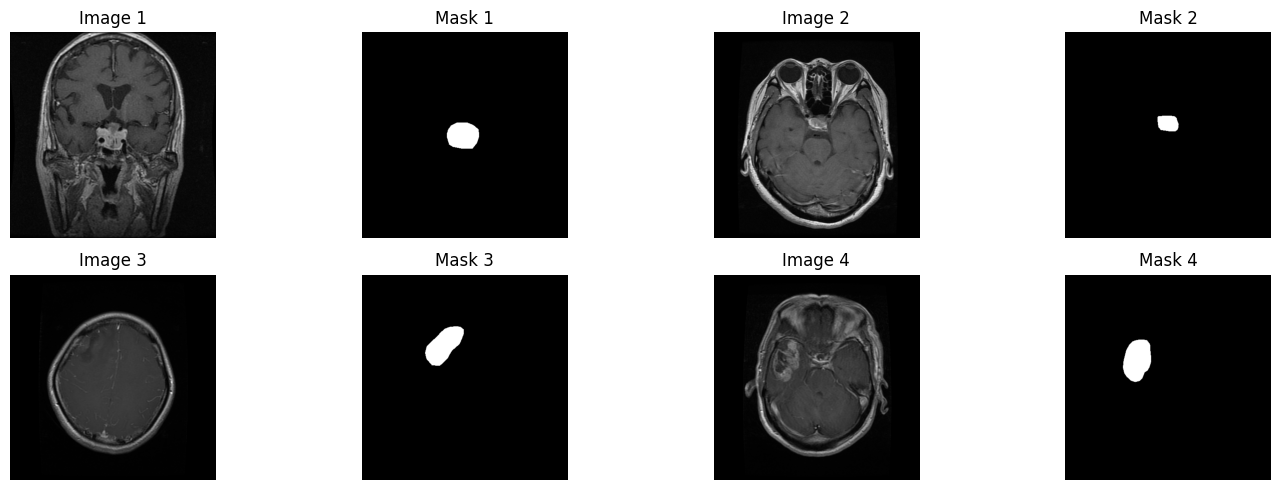

In [ ]:
# showing 4 random images and related masks

import random
import os
img_list = sorted(os.listdir(images_dir))
msk_list = sorted(os.listdir(masks_dir))
selected_pairs = random.sample(list(zip(img_list, msk_list)), k=4)

print(selected_pairs)
plt.figure(figsize=(15,5))
for i,(img_file, msk_file) in enumerate(selected_pairs):
    img_src_path = os.path.join(images_dir, img_file)
    msk_src_path = os.path.join(masks_dir, msk_file)
    plt.subplot(2, 4, 2 * i + 1)
    img = Image.open(img_src_path)
    plt.imshow(img,cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')


    plt.subplot(2, 4, 2 * i + 2)
    msk = Image.open(msk_src_path)
    plt.imshow(msk, cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


# Splitting into train (80%) and remaining (20%)
train_img_list, test_img_list = train_test_split(img_list, test_size=0.2, random_state=12)
train_msk_list, test_msk_list = train_test_split(msk_list, test_size=0.2, random_state=12)



print(f" Training images: {len(train_img_list)},\n Training masks: {len(train_msk_list)}")
print(f" Test images: {len(test_img_list)},\n Test masks: {len(test_msk_list)}")

print(train_img_list[0])

 Training images: 2451,
 Training masks: 2451
 Test images: 613,
 Test masks: 613
2970.png


In [ ]:
import os
from glob import glob


directory = ['/content/test/images' ,'/content/test/masks','/content/train/images','/content/train/masks']




for dir in directory:
  png_files = glob(os.path.join(dir, "*.png"))
  print(len(png_files))


613
613
2451
2451


In [ ]:

train_img_path = '/content/train/images'
train_msk_path = '/content/train/masks'
test_img_path = '/content/test/images'
test_msk_path = '/content/test/masks'

def list_of_dir(dir):
  image_list=[]
  for image in os.listdir(dir):
    image_path = os.path.join(dir, image)
    image_list.append(image_path)
  return image_list



In [ ]:
train_img_list = list_of_dir(train_img_path)
test_img_list = list_of_dir(test_img_path)


train_msk_list= list_of_dir(train_msk_path)
test_msk_list = list_of_dir(test_msk_path)


In [ ]:
test_msk_list[0]

'/content/test/masks/193.png'

In [ ]:
def copy_files(img_list, msk_list, img_src_dir, msk_src_dir, img_dest_dir, msk_dest_dir):
  for image , mask in zip(img_list, msk_list):
    img_path=os.path.join(img_src_dir,image)
    msk_path=os.path.join(msk_src_dir,mask)
    shutil.copy(img_path,img_dest_dir)
    shutil.copy(msk_path,msk_dest_dir)



In [ ]:
copy_files(train_img_list, train_msk_list, '/content/images', '/content/masks', '/content/train/images', '/content/train/masks')

copy_files(test_img_list, test_msk_list, '/content/images', '/content/masks', '/content/test/images', '/content/test/masks')

In [ ]:
train_files = [{"image": img, "seg": mask} for img, mask in zip(train_img_list, train_msk_list)]
test_files = [{"image": img, "seg": mask} for img, mask in zip(test_img_list, test_msk_list)]

In [ ]:
print(train_files[5])
print(len(train_files))
print(len(test_files))


{'image': '/content/train/images/1405.png', 'seg': '/content/train/masks/1405.png'}
2451
613


In [ ]:

from monai.data import Dataset, DataLoader

import torch
from monai.transforms import (
    Compose,EnsureChannelFirstD,CropForegroundd,AddChanneld,Orientationd, LoadImaged, EnsureChannelFirstd, Resized, ScaleIntensityd, ToTensord,AddChanneld
)


train_transforms = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstD(keys=["image", "seg"]),
            Orientationd(keys=["image", "seg"], axcodes="RAS"),
            CropForegroundd(keys=["image", "seg"], source_key="image"),
            Resized(keys=["image", "seg"], spatial_size=[128,128]),
            ToTensord(keys=["image", "seg"]),

        ]
    )

test_transforms = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstD(keys=["image", "seg"]),
            Orientationd(keys=["image", "seg"], axcodes="RAS"),
            CropForegroundd(keys=['image', 'seg'], source_key='image'),
            Resized(keys=["image", "seg"], spatial_size=[128,128]),
            ToTensord(keys=["image", "seg"]),

        ]
    )

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader= DataLoader(test_ds, batch_size=4, shuffle=False)


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
import monai.networks.nets as nets

model = nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2
)


In [ ]:
from monai.losses import DiceLoss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
import torch.optim as optim


In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [ ]:
def train(model, train_loader, test_loader, loss_function, optimizer, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    model.to(device)

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            train_step += 1

            volume = batch_data["image"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = volume.to(device), label.to(device)

            optimizer.zero_grad()
            outputs = model(volume)

            train_loss = loss_function(outputs, label)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            print(f"{train_step}/{len(train_loader)}, Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-' * 20)


        if train_step > 0:
            train_epoch_loss /= train_step
            epoch_metric_train /= train_step
        else:
            train_epoch_loss = float('inf')
            epoch_metric_train = 0.0

        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        print(f'Epoch_metric: {epoch_metric_train:.4f}')
        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:
                    test_step += 1

                    test_volume = test_data["image"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = test_volume.to(device), test_label.to(device)

                    test_outputs = model(test_volume)

                    test_loss = loss_function(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric


                if test_step > 0:
                    test_epoch_loss /= test_step
                    epoch_metric_test /= test_step
                else:
                    test_epoch_loss = float('inf')
                    epoch_metric_test = 0.0

                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


In [ ]:
from monai.losses import DiceLoss


loss_function = DiceLoss(to_onehot_y=False, sigmoid=False, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5, amsgrad=True)

In [ ]:
import shutil

directory_path = '/content/model'

try:
    shutil.rmtree(directory_path)
    print(f"The directory {directory_path} and all its contents have been deleted.")
except Exception as e:
    print(f"Failed to delete {directory_path}. Reason: {e}")


The directory /content/model and all its contents have been deleted.


In [ ]:
!mkdir model

In [ ]:
train(
    model,
    train_loader,
    test_loader,
    loss_function,
    optimizer,
    max_epochs=10,
    model_dir='/content/model',
    test_interval=2,
    device=torch.device("cuda:0")
)


----------
epoch 1/10
1/613, Train_loss: 1.0048
Train_dice: 0.1607
2/613, Train_loss: 1.0136
Train_dice: 0.2538


/usr/local/lib/python3.11/dist-packages/monai/transforms/spatial/array.py:639: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (512, 512), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/losses/dice.py:147: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


3/613, Train_loss: 1.0088
Train_dice: 0.1818
4/613, Train_loss: 1.0114
Train_dice: 0.1213
5/613, Train_loss: 1.0072
Train_dice: 0.1761
6/613, Train_loss: 1.0023
Train_dice: 0.2692
7/613, Train_loss: 1.0127
Train_dice: 0.1927
8/613, Train_loss: 1.0045
Train_dice: 0.1693
9/613, Train_loss: 1.0012
Train_dice: 0.2382
10/613, Train_loss: 1.0019
Train_dice: 0.1405
11/613, Train_loss: 1.0033
Train_dice: 0.1428
12/613, Train_loss: 0.9983
Train_dice: 0.2346
13/613, Train_loss: 0.9965
Train_dice: 0.3086
14/613, Train_loss: 1.0017
Train_dice: 0.0800
15/613, Train_loss: 1.0038
Train_dice: 0.0696
16/613, Train_loss: 0.9961
Train_dice: 0.1949
17/613, Train_loss: 1.0033
Train_dice: 0.1571
18/613, Train_loss: 0.9972
Train_dice: 0.2190
19/613, Train_loss: 0.9994
Train_dice: 0.2073
20/613, Train_loss: 0.9973
Train_dice: 0.2192
21/613, Train_loss: 0.9974
Train_dice: 0.1532
22/613, Train_loss: 0.9986
Train_dice: 0.1323
23/613, Train_loss: 0.9967
Train_dice: 0.1980
24/613, Train_loss: 1.0032
Train_dice: 0.

/usr/local/lib/python3.11/dist-packages/monai/transforms/spatial/array.py:639: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (256, 256), channels = 1,please make sure the input is in the channel-first format.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
580/613, Train_loss: 0.2801
Train_dice: 0.0559
581/613, Train_loss: 0.4060
Train_dice: 0.1100
582/613, Train_loss: 0.2111
Train_dice: 0.1460
583/613, Train_loss: 0.3175
Train_dice: 0.0741
584/613, Train_loss: 0.2760
Train_dice: 0.1291
585/613, Train_loss: 0.4069
Train_dice: 0.0367
586/613, Train_loss: 0.2040
Train_dice: 0.0775
587/613, Train_loss: 0.4847
Train_dice: 0.1130
588/613, Train_loss: 0.2122
Train_dice: 0.1173
589/613, Train_loss: 0.3397
Train_dice: 0.0603
590/613, Train_loss: 0.4459
Train_dice: 0.1158
591/613, Train_loss: 0.3723
Train_dice: 0.1037
592/613, Train_loss: 0.3089
Train_dice: 0.1022
593/613, Train_loss: 0.4408
Train_dice: 0.1000
594/613, Train_loss: 0.3074
Train_dice: 0.0881
595/613, Train_loss: 0.1671
Train_dice: 0.0741
596/613, Train_loss: 0.3327
Train_dice: 0.1078
597/613, Train_loss: 0.2210
Train_dice: 0.0929
598/613, Train_loss: 0.2898
Train_dice: 0.1204
599/613, Train_loss: 0.2466
Train_dice: 0.0954
600/613, 

In [ ]:
def show_patient(data_loader, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can see if the it is okay or you need
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize
    the patient with the transforms that you want.


    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)

    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """



    if train:
        batch = next(iter(data_loader))

        image = batch['image'][0].cpu().numpy()
        label = batch['seg'][0].cpu().numpy()

        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title('image')
        plt.imshow(image[0], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label[0])
        plt.show()

    if test:
        batch = next(iter(data_loader))

        image = batch['image'][0].cpu().numpy()
        label = batch['seg'][0].cpu().numpy()


        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title('image')
        plt.imshow(image[0], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title('label')
        plt.imshow(label[0])
        plt.show()



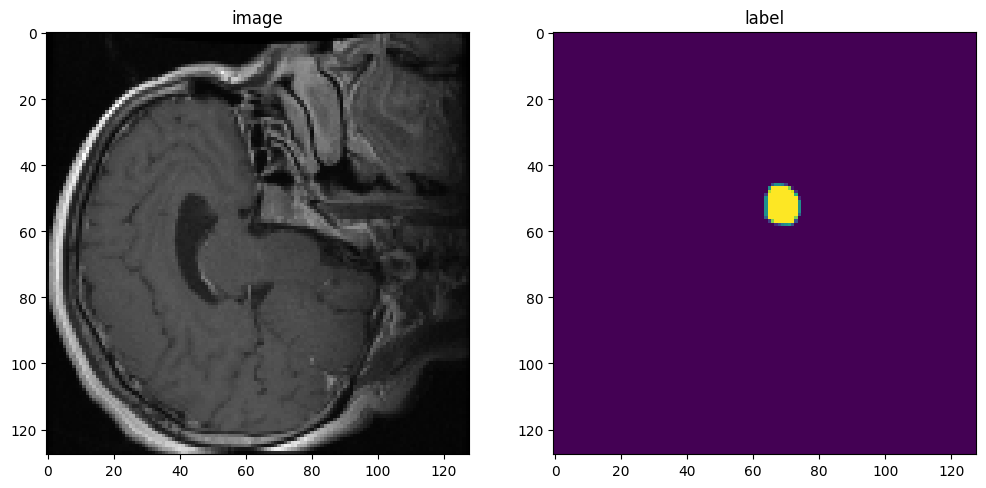

In [ ]:
show_patient(train_loader, train=True, test=False)

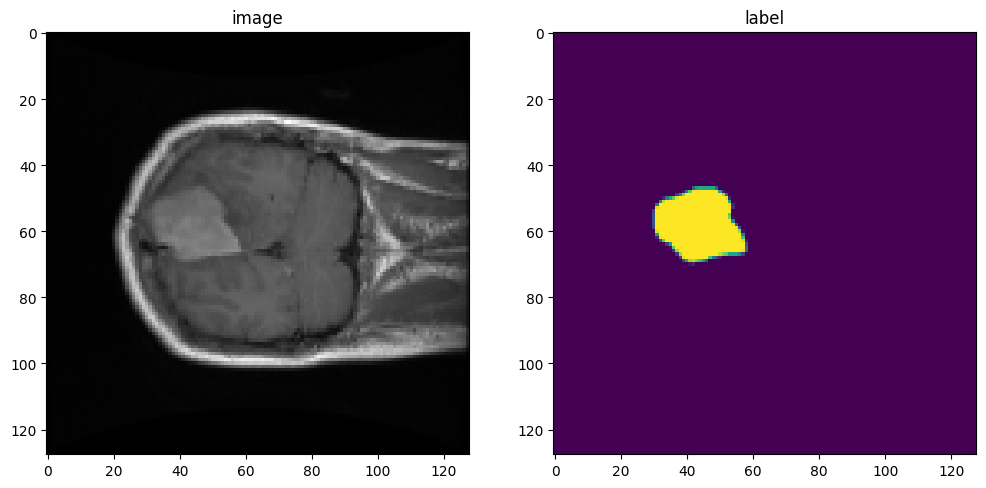

In [ ]:
show_patient(test_loader, train=False, test=True)

In [ ]:
model_dir = '/content/model'


In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

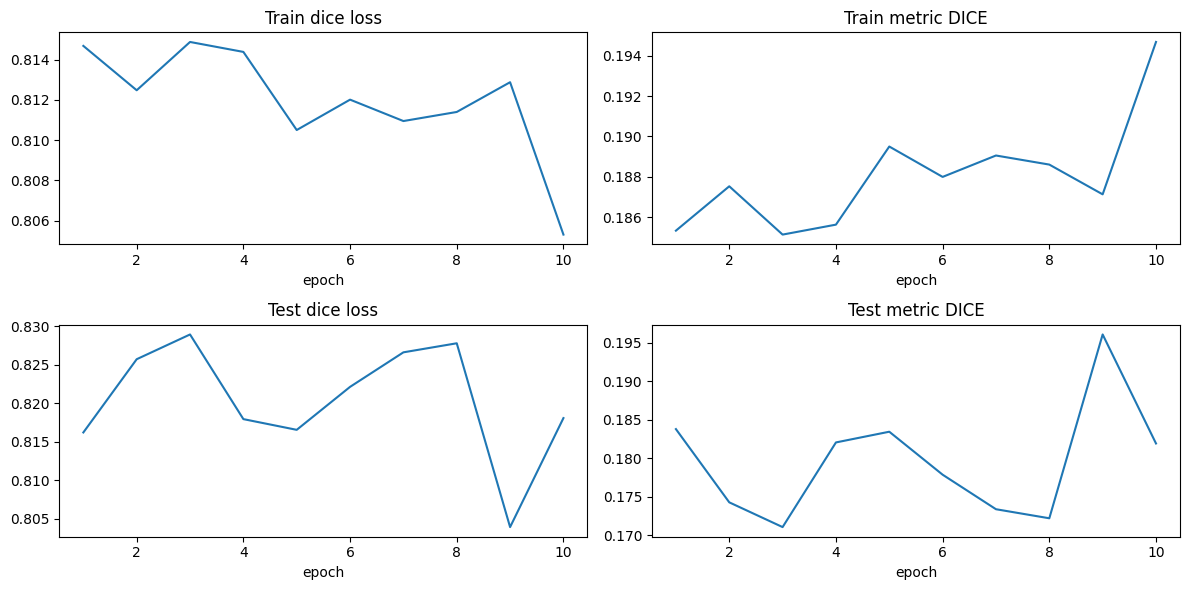

In [ ]:
plt.figure("Results", (12, 6))

plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.tight_layout()
plt.show()


In [ ]:
model.load_state_dict(torch.load(
    os.path.join('/content/model', "best_metric_model.pth")))
model.eval()

<ipython-input-96-4203163940d3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

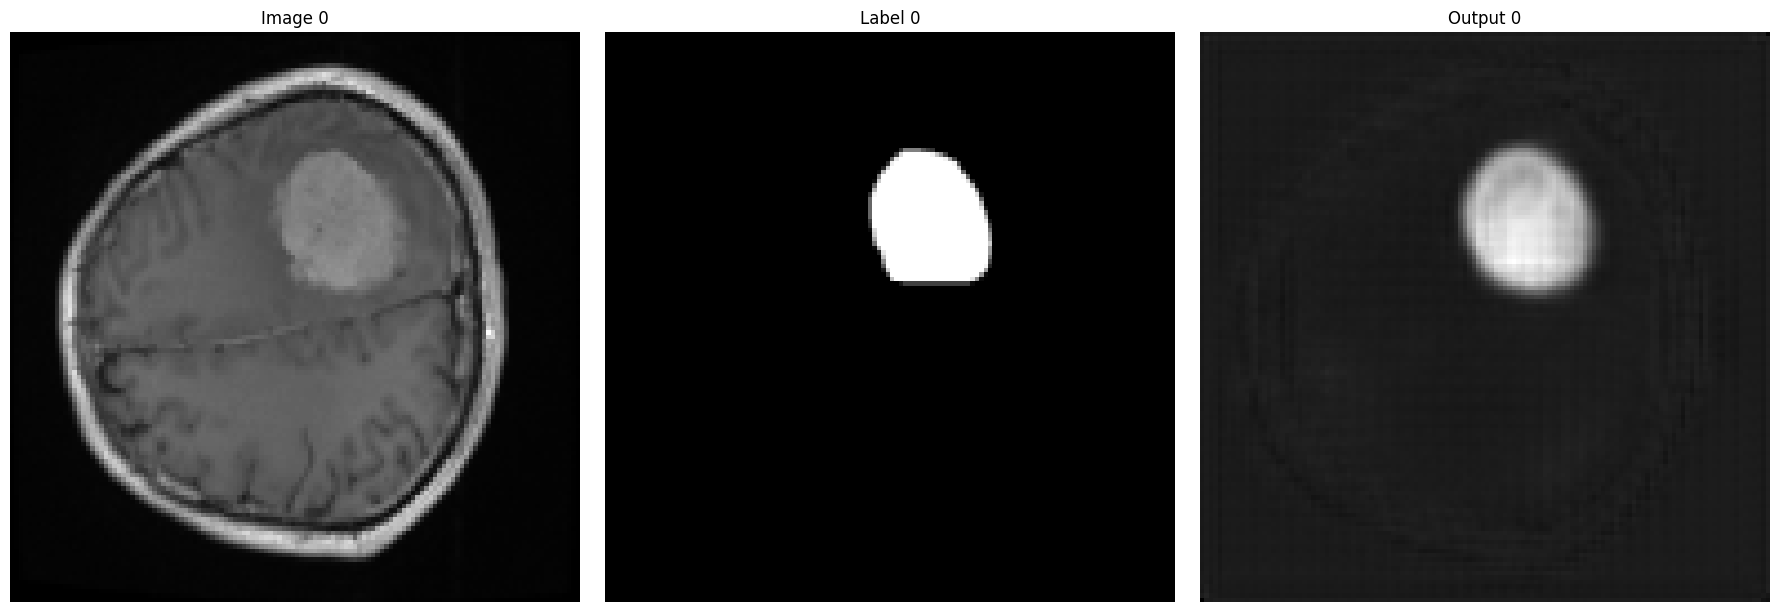

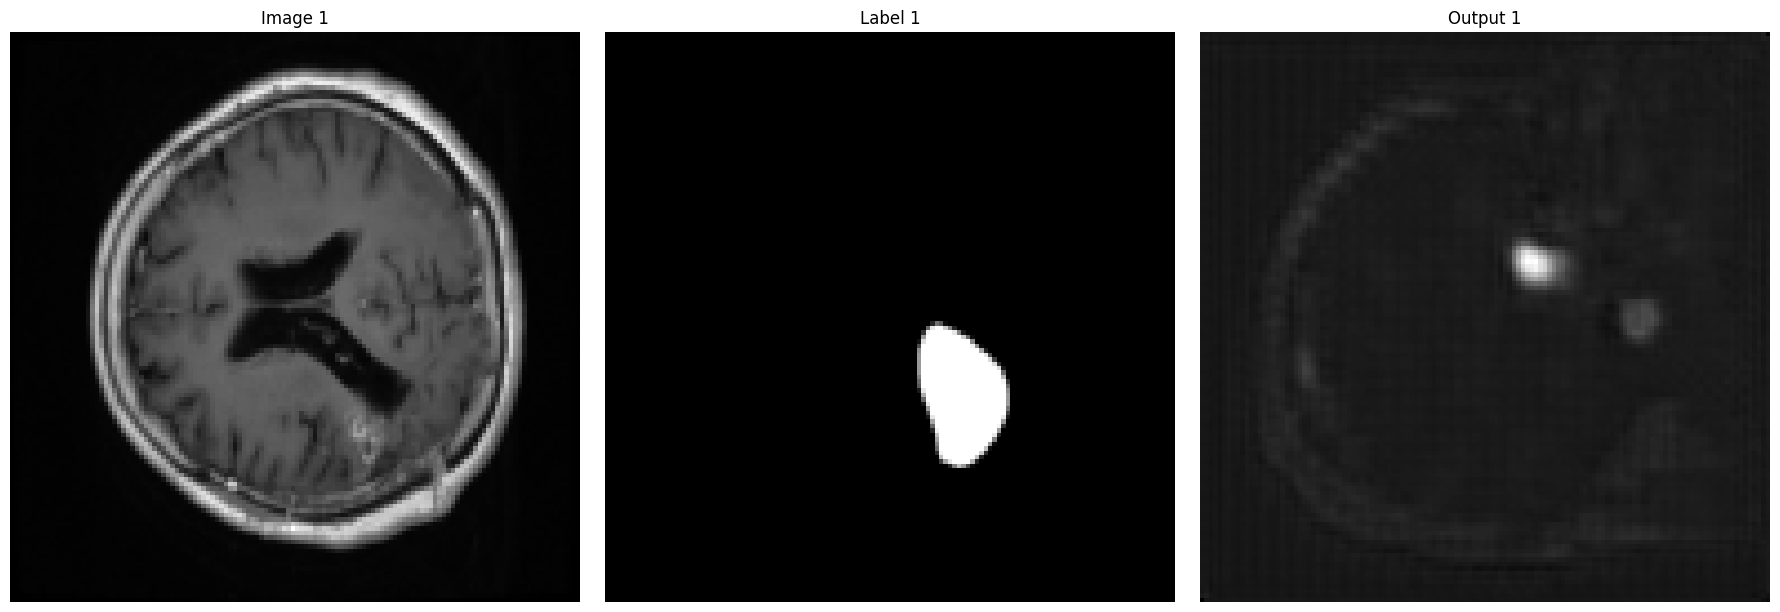

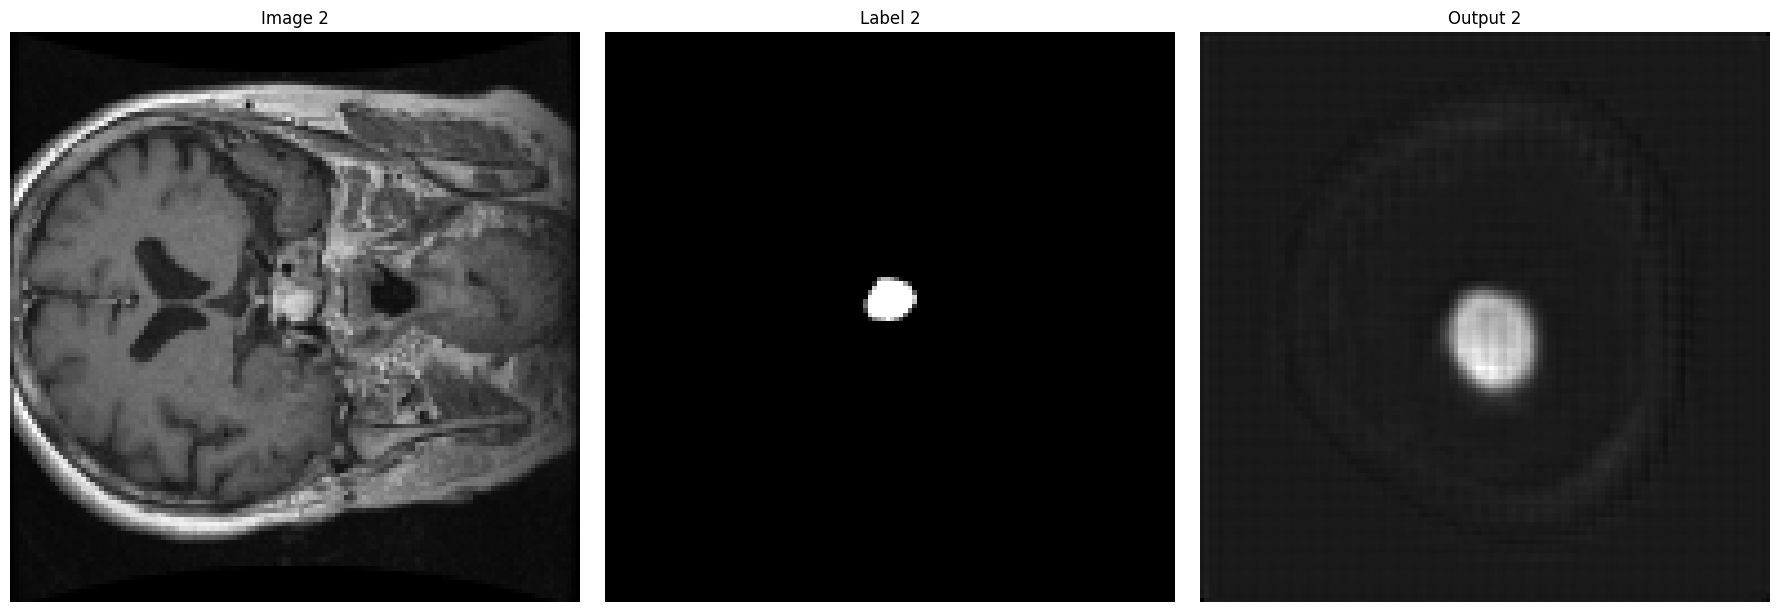

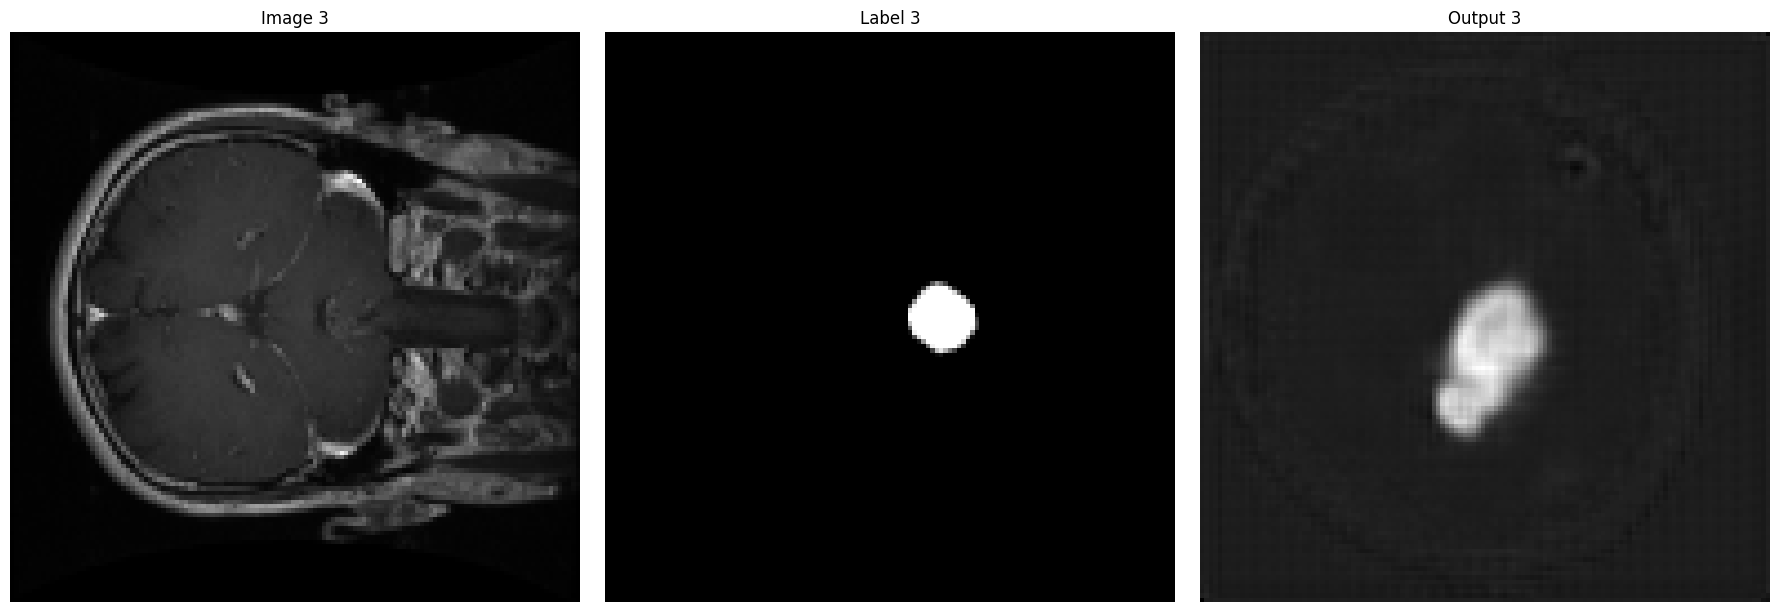

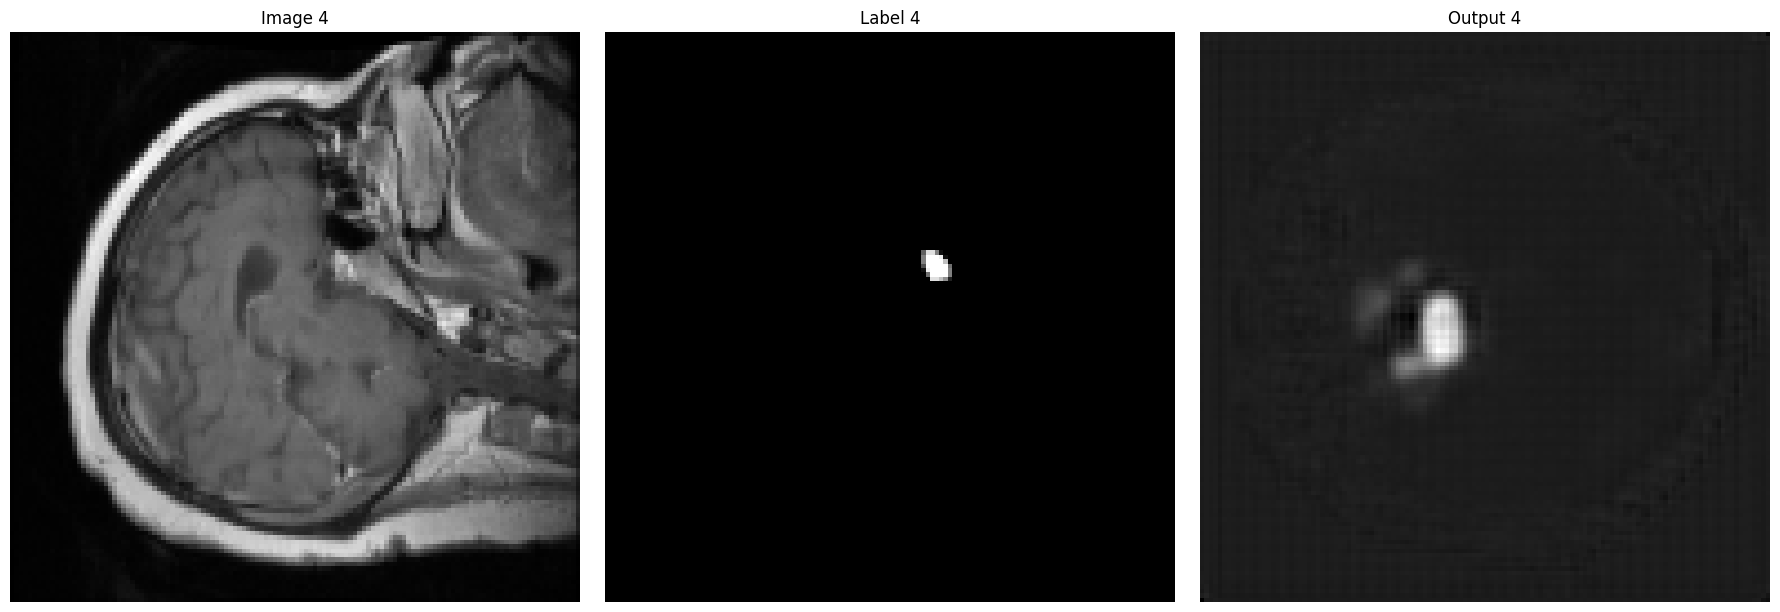

In [ ]:
def run_inference(model, dataloader, device):
    model.eval()
    results = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            outputs = model(images)
            results.append(outputs.cpu().numpy())

    return results

results = run_inference(model, test_loader, device)

for i in range(5):
    sample_image = test_loader.dataset[i]['image'][0]
    sample_label = test_loader.dataset[i]['seg'][0]
    sample_output = results[i][0]

    # Squeeze the sample_output to remove the extra dimension
    sample_output = np.squeeze(sample_output)

    plt.figure(f"Sample {i}", (18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Image {i}")
    plt.imshow(sample_image, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Label {i}")
    plt.imshow(sample_label, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Output {i}")
    plt.imshow(sample_output ,cmap="gray")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
